In [20]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "bomb.png", width=600)

In [1]:
from bs4 import BeautifulSoup
from urllib import request
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import display, clear_output
import warnings
import seaborn as sns

%matplotlib inline

In [2]:
# reading in data
wikipedia = 'https://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900'
handler = request.urlopen(wikipedia)
soup = BeautifulSoup(handler.read(), 'html.parser')
table = soup.find_all(class_='wikitable')[0]
df = pd.read_html(str(table), header=0)[0]

# manually reading
'''trs = table.find_all('tr')

header = trs.pop(0)
ths = header.find_all('th')

headers = [x.text for x in ths]
data = []

for row in trs:
    tds = row.find_all('td')
    data.append([f.text for f in tds])
    
df = pd.DataFrame.from_records(data, columns=headers)'''

"trs = table.find_all('tr')\n\nheader = trs.pop(0)\nths = header.find_all('th')\n\nheaders = [x.text for x in ths]\ndata = []\n\nfor row in trs:\n    tds = row.find_all('td')\n    data.append([f.text for f in tds])\n    \ndf = pd.DataFrame.from_records(data, columns=headers)"

In [3]:
# replacing footnotes and other crap
pattern = r'\(.*\)|\[.*\]|\D'
df['Other Source Deaths'] = df['Other Source Deaths'].str.replace(pattern, "")
df['EM-DAT Total Deaths'] = df['EM-DAT Total Deaths'].str.replace(pattern, "")

# replacing magnitude with number
pattern = r'([^\.\d]).*'
df['Magnitude'] = df['Magnitude'].str.replace(pattern, '')

# replacing unclean longs and lats
pattern = r'\?\??'
df['Long'] = df['Long'].replace(pattern, np.nan, regex=True)
df['Lat'] = df['Lat'].replace(pattern, np.nan, regex=True)
df['Depth (km)'] = df['Depth (km)'].replace(pattern, np.nan, regex=True)


# converting to numericdf['Long'] = pd.to_numeric(df['Long'])
df['Lat'] = pd.to_numeric(df['Lat'])
df['Long'] = pd.to_numeric(df['Long'])
df['Magnitude'] = pd.to_numeric(df['Magnitude'])
df['Other Source Deaths'] = pd.to_numeric(df['Other Source Deaths'])
df['PDE Total Deaths'] = pd.to_numeric(df['PDE Total Deaths'])
df['Utsu Total Deaths'] = pd.to_numeric(df['Utsu Total Deaths'])
df['EM-DAT Total Deaths'] = pd.to_numeric(df['EM-DAT Total Deaths'])
df['Depth (km)'] = pd.to_numeric(df['Depth (km)'])


# creating new deaths column with max
df['Deaths'] = df[['PDE Total Deaths', 'Utsu Total Deaths', 'EM-DAT Total Deaths', 'Other Source Deaths']].max(axis=1)
df.columns.values[1] = 'Country'

# cleaning countries
pattern = r'(, ?| ?\().*'
df['Country'] = df['Country'].str.replace(pattern, '')

HBox(children=(FloatRangeSlider(value=(2.0, 9.5), continuous_update=False, description='Magnitude', max=9.5, min=2.0), Dropdown(description='Country', index=18, options=('ALL', 'Afghanistan', 'Albania', 'Algeria', 'Argentina', 'Armenia', 'Australia', 'Azerbaijan', 'Bangladesh', 'Belgium', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Burma', 'Burundi', 'Canada', 'Chile', 'China', 'Colombia', 'Costa Rica', 'Cuba', 'Cyprus', 'Czech Republic', 'Democratic Republic of the Congo', 'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'England', 'Eritrea', 'Ethiopia', 'Fiji', 'France', 'Georgia', 'Ghana', 'Greece', 'Guadeloupe', 'Guatemala', 'Guinea', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Italy', 'Jamaica', 'Japan', 'Judea and Samaria', 'Kazakhstan', 'Kingdom of Yugoslavia', 'Kyrgyzstan', 'Macedonia', 'Malawi', 'Malaysia', 'Mandatory Palestine and Transjordan', 'Martinique', 'Mexico', 'Mongolia', 'Montenegro', 'Morocco', 'Mozambique', 'Nepal', 'Netherlands', 'New Zealand', 'Nicaragua', 'Pakistan', 'Panama', 'Papua New Guinea', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Puerto Rico', 'Romania', 'Russian Federation', 'Rwanda', 'Saint Pierre and Miquelon', 'Samoa', 'Saudi Arabia/Egypt', 'Serbia', 'Slovenia', 'Solomon Islands', 'South Africa', 'Spain', 'Sudan', 'Syrian Arab Republic', 'Taiwan', 'Tajik Soviet Socialist Republic', 'Tajikistan', 'Tanzania', 'Tunisia', 'Turkey', 'Turkmenistan', 'US Territory of Alaska', 'Uganda', 'United States', 'United States Minor Outlying Islands', 'Uzbekistan', 'Vanuatu', 'Venezuela', 'Vietnam', 'Wallis and Futuna', 'Yemen', 'Yugoslavia'), value='China')))

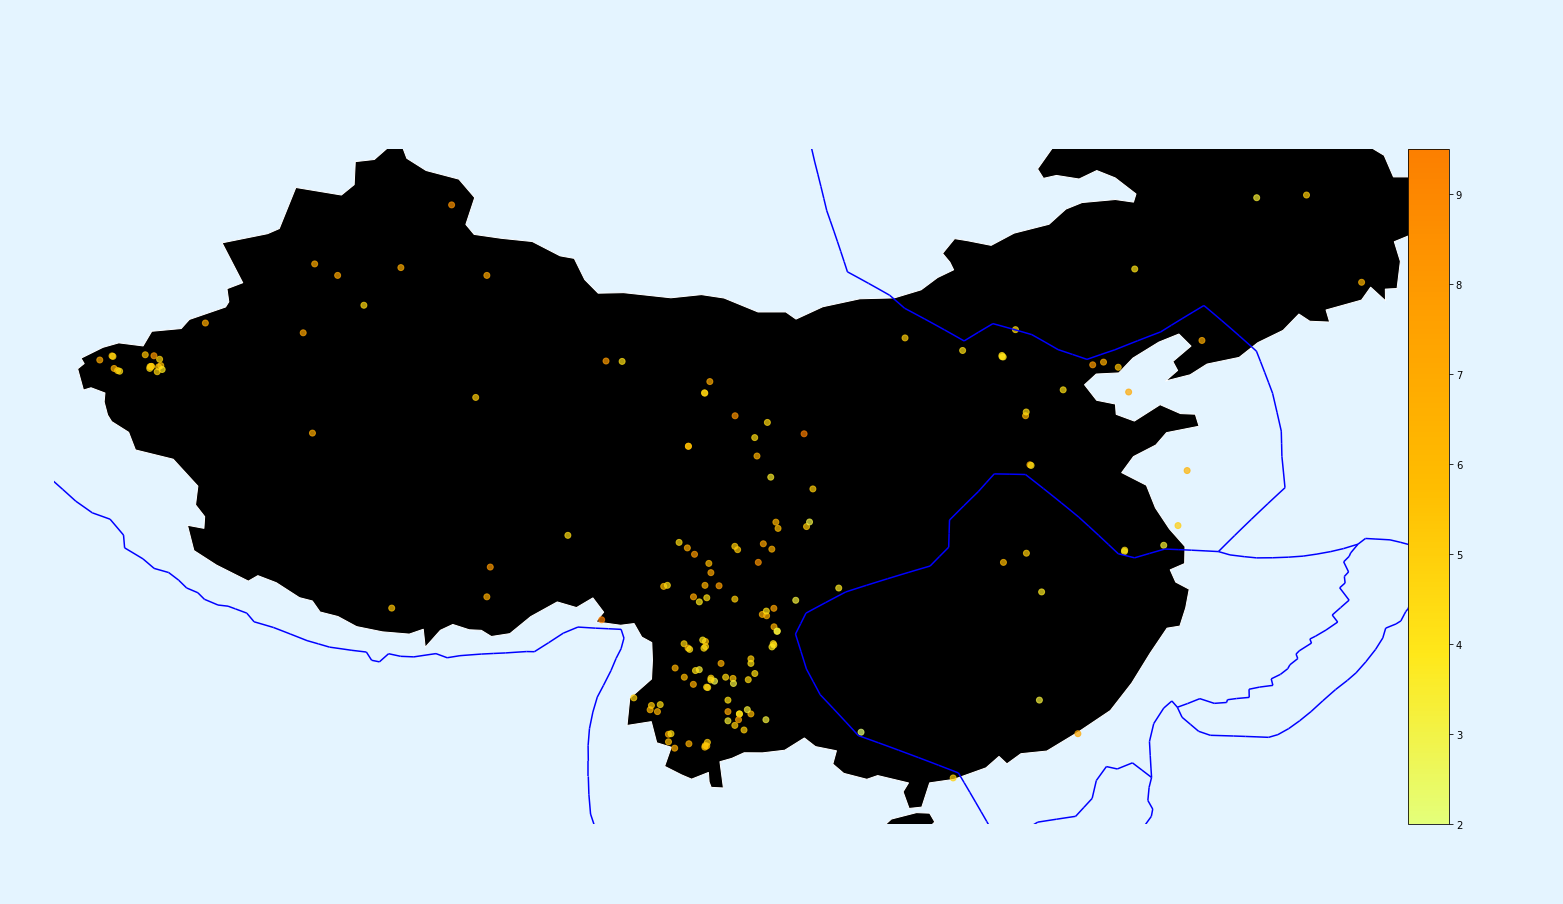

In [19]:
## repeated below to re-display graph ##
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
geometry = [Point(x) for x in zip(df["Long"], df["Lat"])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

fname = "PB2002_steps.json"
boundaries = gpd.read_file(fname)

countries = sorted(list(set(gdf.Country)))
countries.insert(0, 'ALL')
countries.remove("")

ax = world.plot(color='black', edgecolor='white', figsize=(25,55))
ax.axis('off')
boundaries.plot(ax=ax, color='blue', markersize=15)
gdf.plot(ax=ax, column='Magnitude', alpha=0.4, cmap='Wistia');
fig = ax.get_figure()
fig.patch.set_facecolor('#e4f4ff')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.01)
sm = plt.cm.ScalarMappable(cmap='Wistia', norm=plt.Normalize(vmin=2.0, vmax=10.0))
sm._A = []
fig.colorbar(sm,cax=cax)
## repeated below to re-display graph ##

country = 'ALL'
minimum = 2.0
maximum = 9.5
world_copy = world.copy()
limits = False

m = widgets.FloatRangeSlider(
    value=(0, 15),
    min=gdf['Magnitude'].min(),
    max=gdf['Magnitude'].max(),
    description='Magnitude',
    continuous_update=False,
)

countries = sorted(list(set(gdf.Country)))
countries.insert(0, 'ALL')
countries.remove("")

d = widgets.Dropdown(
    options=countries,
    value='ALL',
    description='Country',
    disabled=False,
)

z = widgets.HBox([m,d])
display(z)

def response(change):
    try:
        clear_output(wait=True)
        global country
        global maximum
        global minimum
        global world_copy
        global limits
        if len(change['new']) == 2:
            maximum = change['new'][1]
            minimum = change['new'][0]
        else:
            country = change['new']
        display(z)
        if country.upper() == 'ALL':
            display_df = gdf[(gdf["Magnitude"] >= minimum) & (gdf['Magnitude'] <= maximum)]
            world_copy = world
            limits = False
        else:
            display_df = gdf[(gdf["Magnitude"] >= minimum) & (gdf['Magnitude'] <= maximum) & (gdf['Country'].str.upper() == country.upper())]
            world_copy = world[world['name'].str.upper() == country.upper()]
            xmin = display_df['Long'].min()
            xmax = display_df['Long'].max()
            ymin = display_df['Lat'].min()
            ymax = display_df['Lat'].max()
            limits = True
        
        ax = world_copy.plot(color='black', edgecolor='white', figsize=(25,55))
        ax.axis('off')
        boundaries.plot(ax=ax, color='blue', markersize=8)
        if limits:
            plt.xlim(xmin - 2.0, xmax + 2.0)
            plt.ylim(ymin - 2.0, ymax + 2.0)
        display_df.plot(ax=ax, column='Magnitude', alpha=0.7, cmap='Wistia');
        fig = ax.get_figure()
        fig.patch.set_facecolor('#e4f4ff')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='3%', pad=0.01)
        sm = plt.cm.ScalarMappable(cmap='Wistia', norm=plt.Normalize(vmin=minimum, vmax=maximum)) 
        sm._A = []
        fig.colorbar(sm,cax=cax)
    except:
        print("Ain't no earthgdf of this magnitude in this country... Try again")
        warnings.filterwarnings('ignore')
            
m.observe(response, names='value')
d.observe(response, names='value')

HBox(children=(FloatRangeSlider(value=(0.0, 10.0), continuous_update=False, description='Magnitude', max=10.0), Dropdown(description='Country', options=('ALL', 'Afghanistan', 'Albania', 'Algeria', 'Argentina', 'Armenia', 'Australia', 'Azerbaijan', 'Bangladesh', 'Belgium', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Burma', 'Burundi', 'Canada', 'Chile', 'China', 'Colombia', 'Costa Rica', 'Cuba', 'Cyprus', 'Czech Republic', 'Democratic Republic of the Congo', 'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'England', 'Eritrea', 'Ethiopia', 'Fiji', 'France', 'Georgia', 'Ghana', 'Greece', 'Guadeloupe', 'Guatemala', 'Guinea', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Italy', 'Jamaica', 'Japan', 'Judea and Samaria', 'Kazakhstan', 'Kingdom of Yugoslavia', 'Kyrgyzstan', 'Macedonia', 'Malawi', 'Malaysia', 'Mandatory Palestine and Transjordan', 'Martinique', 'Mexico', 'Mongolia', 'Montenegro', 'Morocco', 'Mozambique', 'Nepal', 'Netherlands', 'New Zealand', 'Nicaragua', 'Pakistan', 'Panama', 'Papua New Guinea', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Puerto Rico', 'Romania', 'Russian Federation', 'Rwanda', 'Saint Pierre and Miquelon', 'Samoa', 'Saudi Arabia/Egypt', 'Serbia', 'Slovenia', 'Solomon Islands', 'South Africa', 'Spain', 'Sudan', 'Syrian Arab Republic', 'Taiwan', 'Tajik Soviet Socialist Republic', 'Tajikistan', 'Tanzania', 'Tunisia', 'Turkey', 'Turkmenistan', 'US Territory of Alaska', 'Uganda', 'United States', 'United States Minor Outlying Islands', 'Uzbekistan', 'Vanuatu', 'Venezuela', 'Vietnam', 'Wallis and Futuna', 'Yemen', 'Yugoslavia'), value='ALL')))

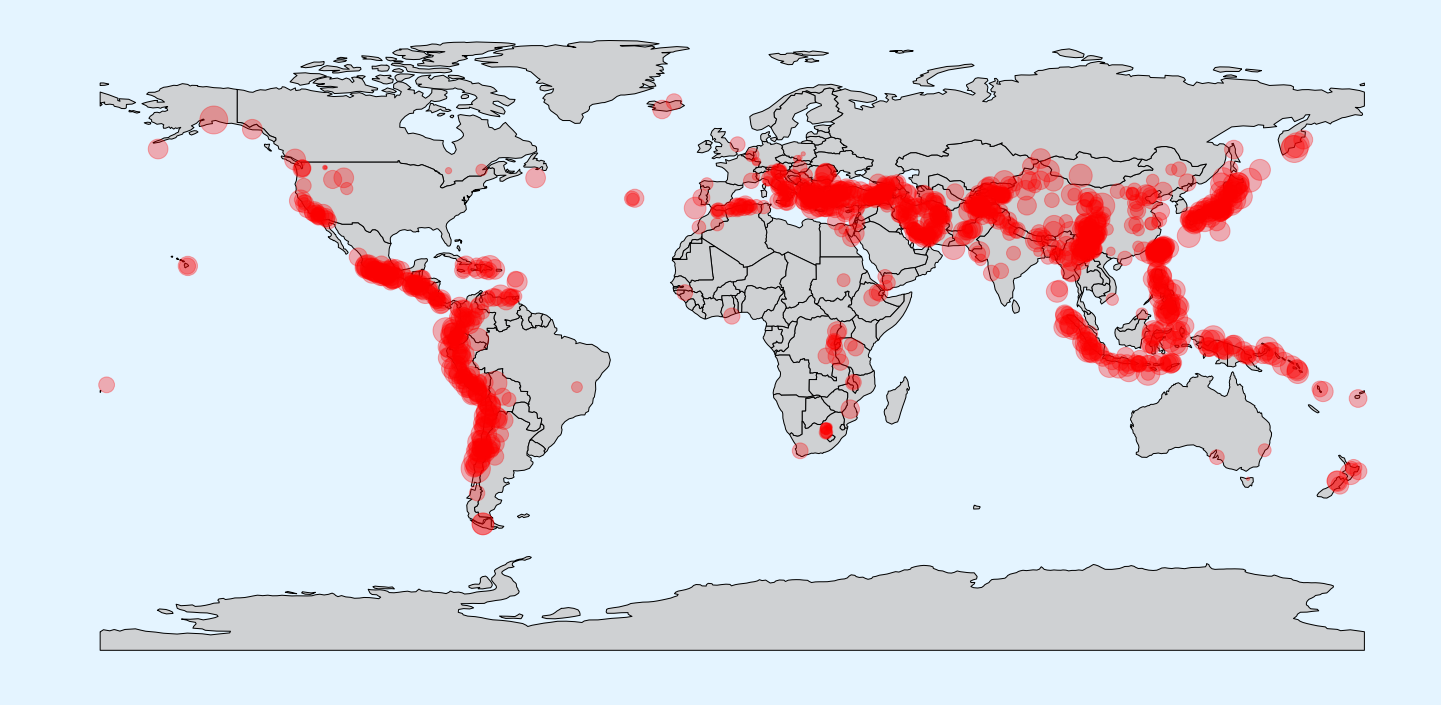

In [5]:
# map plots sized by magnitude
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
geometry = [Point(x) for x in zip(df["Long"], df["Lat"])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

countries = sorted(list(set(gdf.Country)))
countries.insert(0, 'ALL')
countries.remove("")

w = widgets.FloatRangeSlider(value=(0,10), min=0, max=10, continuous_update=False, description='Magnitude')
m = widgets.Dropdown(options=countries, value='ALL', description='Country', disabled=False,)
z = widgets.HBox([w,m])
display(z)

ax = world.plot(color='#cfd1d3', edgecolor='black', figsize=(25,55))
ax.axis('off')
plt.scatter(x=gdf['Long'], y=gdf['Lat'], s=gdf['Magnitude']**3, alpha=0.3, c='red')
fig = ax.get_figure()
fig.patch.set_facecolor('#e4f4ff')

maximum = 10
minimum = 0
country = "ALL"
world_copy = world.copy()

def response(change):
    print(change)
    try:
        clear_output(wait=True)
        global country
        global maximum
        global minimum
        global world_copy
        if len(change['new']) == 2:
            maximum = change['new'][1]
            minimum = change['new'][0]
        else:
            country = change['new']
        display(z)

        if country.upper() == 'ALL':
            display_df = gdf[(gdf["Magnitude"] >= minimum) & (gdf['Magnitude'] <= maximum)]
            world_copy = world
        else:
            display_df = gdf[(gdf["Magnitude"] >= minimum) & (gdf['Magnitude'] <= maximum) & (gdf['Country'].str.upper() == country.upper())]
            world_copy = world[world['name'].str.upper() == country.upper()]

        #display_df = gdf[(gdf["Magnitude"] >= minimum) & (gdf['Magnitude'] <= maximum)]


        ax = world_copy.plot(color='#cfd1d3', edgecolor='black', figsize=(25,55))
        ax.axis('off')
        plt.scatter(x=display_df['Long'], y=display_df['Lat'], s=gdf['Magnitude']**3, alpha=0.3, c='red')
        fig = ax.get_figure()
        fig.patch.set_facecolor('#e4f4ff')

    except:
        print("Ain't no earthquakes of this magnitude in this area... Try again")
        warnings.filterwarnings('ignore')
        
w.observe(response, names='value')
m.observe(response, names='value')

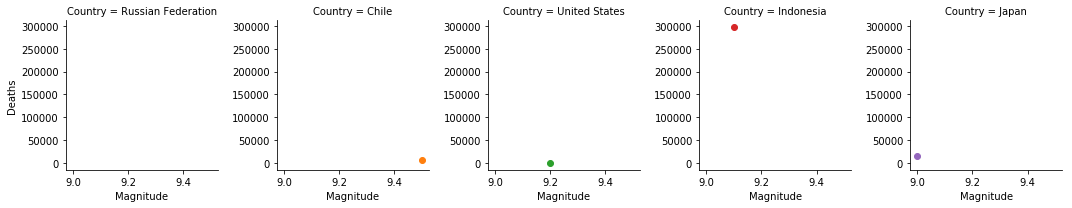

In [6]:
df['Origin (UTC)'] = pd.to_datetime(df['Origin (UTC)'])
df['Year'] = df['Origin (UTC)'].dt.year

df_max_deaths = df.loc[df['Deaths'].isin(list(df.Deaths.nlargest(5)))]
df_max_magnitude=df.loc[df['Magnitude'].isin(list(df.Magnitude.nlargest(5)))]

map_max_magnitude = sns.FacetGrid(df_max_magnitude,col="Country",hue="Year");
map_max_magnitude.map(plt.plot,"Magnitude","Deaths",marker="o");

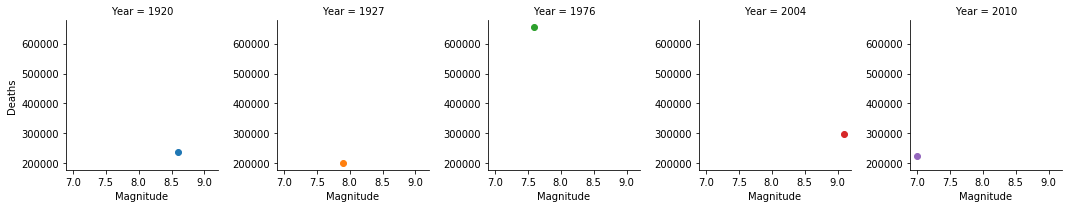

In [7]:
map_max_deaths = sns.FacetGrid(df_max_deaths,col="Year",hue="Year");
map_max_deaths.map(plt.plot,"Magnitude","Deaths",marker="o");

/anaconda3/envs/dq2/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/anaconda3/envs/dq2/lib/python3.6/site-packages/numpy/lib/function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


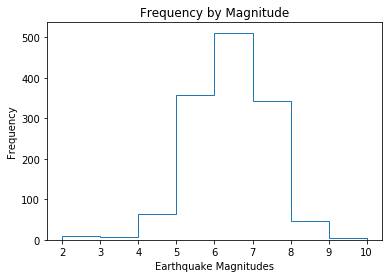

In [8]:
total = len(df)
n, bins, patch = plt.hist(df["Magnitude"], histtype = 'step', range=(2.0,10.0), bins = 8)
plt.xlabel("Earthquake Magnitudes")
plt.ylabel("Frequency")
plt.title("Frequency by Magnitude")
histo = pd.DataFrame()
for i in range(0, len(n)):
    mag = str(bins[i]) + "-" + str(bins[i+1])
    freq = n[i]
    percentage = round((n[i]/total) * 100, 4)
    histo = histo.append(pd.Series([mag, freq, percentage]), ignore_index=True)
    
histo.columns = ['Range of Magnitude', 'Frequency', 'Percentage']
histo
warnings.filterwarnings('ignore')

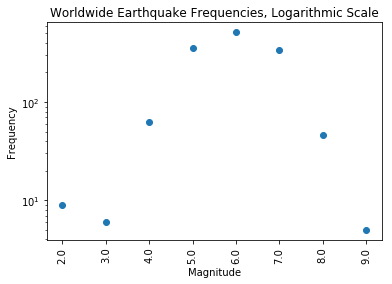

In [9]:
fig, ax = plt.subplots()
#ax.plot(histo.index, fit[0] * histo.index + fit[1], color='red')
ax.scatter(histo.index, histo['Frequency'])
plt.xticks(histo.index, bins, rotation='vertical')
plt.yscale('log')

plt.xlabel("Magnitude")
plt.ylabel("Frequency")
plt.title("Worldwide Earthquake Frequencies, Logarithmic Scale")
fig.show()

This pattern is known as a power-law distribution: it turns out that for every increase of one point in magnitude, an earthquake becomes about ten times less frequent. So, for example, magnitude 6.5 earthquakes occur ten times more frequently than magnitude 7's, and one hundred times more often than magnitude 8's.

We can use this to relatively calculate the probability that an earthquake will hit a particular region, although it is impossible to know exactly when. For example, if we know that there were 15 earthquakes between 5.0 and 5.9 in a particular region in a period of 70 years, that works to about one earthquake in three years. Following this distribution above, we can "predict" that an earthquake measuring between 6.0 and 6.9 should occur about once every thirty years in this region.

Dropdown(description='Year', options=(2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004, 2003, 2002, 2001, 2000, 1999, 1998, 1997, 1996, 1995, 1994, 1993, 1992, 1991, 1990, 1989, 1988, 1987, 1986, 1985, 1984, 1983, 1982, 1981, 1980, 1979, 1978, 1977, 1976, 1975, 1974, 1973, 1972, 1971, 1970, 1969, 1968, 1967, 1966, 1965, 1964, 1963, 1962, 1961, 1960, 1959, 1958, 1957, 1956, 1955, 1954, 1953, 1952, 1951, 1950, 1949, 1948, 1947, 1946, 1945, 1944, 1943, 1942, 1941, 1940, 1939, 1938, 1937, 1936, 1935, 1934, 1933, 1932, 1931, 1930, 1929, 1928, 1927, 1926, 1925, 1924, 1923, 1922, 1921, 1920, 1919, 1918, 1917, 1916, 1915, 1914, 1913, 1912, 1911, 1910, 1909, 1908, 1907, 1906, 1905, 1904, 1903, 1902, 1901, 1900), value=2011)

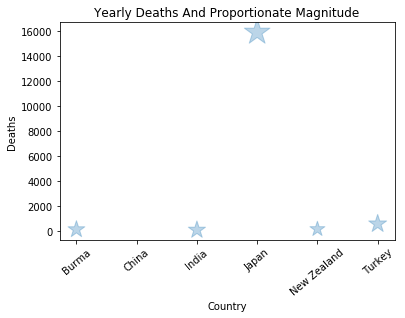

          Country     Lat     Long  Magnitude   Deaths
1333  New Zealand     NaN      NaN        6.3    181.0
1334        China     NaN      NaN        5.4      NaN
1335        Japan  38.322  142.369        9.0  15894.0
1336        Burma     NaN      NaN        6.8    150.0
1337        Japan  38.200  140.000        7.1      NaN
1338        India  27.723   88.064        6.9    111.0
1339       Turkey  38.600   43.500        7.1    601.0


In [10]:
gdf['Origin (UTC)'] = pd.to_datetime(gdf["Origin (UTC)"])
gdf['Year'] = gdf['Origin (UTC)'].dt.year
years = sorted(list(set(gdf['Year'])))
years.reverse()

yearly = gdf.loc[gdf['Year'] == years[0]]

y = widgets.Dropdown(
    options=years,
    value=years[0],
    description='Year',
    disabled=False)

display(y)

plt.xticks(rotation=40)
plt.title('Yearly Deaths And Proportionate Magnitude')
plt.xlabel('Country')
plt.ylabel('Deaths')
plt.scatter(x=yearly['Country'], y=yearly['Deaths'], marker='*', alpha=0.3, s=yearly['Magnitude']**3)
plt.show()
print(yearly.loc[:, ['Country', 'Lat', 'Long', 'Magnitude', 'Deaths']])

def scatter_response(year_change):
    clear_output(wait=True)
    year = year_change['new']
    yearly = gdf.loc[gdf['Year'] == year]
    display(y)
    plt.xticks(rotation=40)
    plt.title('Yearly Deaths And Proportionate Magnitude')
    plt.xlabel('Country')
    plt.ylabel('Deaths')
    plt.scatter(x=yearly['Country'], y=yearly['Deaths'], marker='*', alpha=0.3, s=yearly['Magnitude']**3)
    plt.show()
    print(yearly.loc[:, ['Country', 'Lat', 'Long', 'Magnitude', 'Deaths']])
    
y.observe(scatter_response, names='value')

Dropdown(description='Country', options=('ALL', 'Afghanistan', 'Albania', 'Algeria', 'Argentina', 'Armenia', 'Australia', 'Azerbaijan', 'Bangladesh', 'Belgium', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Burma', 'Burundi', 'Canada', 'Chile', 'China', 'Colombia', 'Costa Rica', 'Cuba', 'Cyprus', 'Czech Republic', 'Democratic Republic of the Congo', 'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'England', 'Eritrea', 'Ethiopia', 'Fiji', 'France', 'Georgia', 'Ghana', 'Greece', 'Guadeloupe', 'Guatemala', 'Guinea', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Italy', 'Jamaica', 'Japan', 'Judea and Samaria', 'Kazakhstan', 'Kingdom of Yugoslavia', 'Kyrgyzstan', 'Macedonia', 'Malawi', 'Malaysia', 'Mandatory Palestine and Transjordan', 'Martinique', 'Mexico', 'Mongolia', 'Montenegro', 'Morocco', 'Mozambique', 'Nepal', 'Netherlands', 'New Zealand', 'Nicaragua', 'Pakistan', 'Panama', 'Papua New Guinea', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Puerto Rico', 'Romania', 'Russian Federation', 'Rwanda', 'Saint Pierre and Miquelon', 'Samoa', 'Saudi Arabia/Egypt', 'Serbia', 'Slovenia', 'Solomon Islands', 'South Africa', 'Spain', 'Sudan', 'Syrian Arab Republic', 'Taiwan', 'Tajik Soviet Socialist Republic', 'Tajikistan', 'Tanzania', 'Tunisia', 'Turkey', 'Turkmenistan', 'US Territory of Alaska', 'Uganda', 'United States', 'United States Minor Outlying Islands', 'Uzbekistan', 'Vanuatu', 'Venezuela', 'Vietnam', 'Wallis and Futuna', 'Yemen', 'Yugoslavia'), value='ALL')

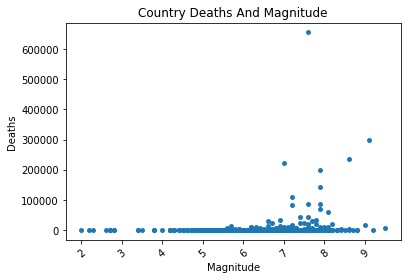

In [11]:
c_gdf = gdf.copy()

c = widgets.Dropdown(options=countries, value='ALL', description='Country', disabled=False,)

display(c)

plt.xticks(rotation=40)
plt.title('Country Deaths And Magnitude')
plt.ylabel('Deaths')
plt.xlabel('Magnitude')
plt.scatter(x=c_gdf['Magnitude'], y=c_gdf['Deaths'], marker='o', s=15)
plt.show()

def magnitude_response(country_change):
    clear_output(wait=True)
    country = country_change['new']
    if country.upper() == 'ALL':
        c_gdf = gdf.copy()
    else:
        c_gdf = gdf.loc[gdf['Country'].str.upper() == country.upper()]
    display(c)
    plt.xticks(rotation=40)
    plt.title('Country Deaths And Proportionate Magnitude')
    plt.ylabel('Deaths')
    plt.xlabel('Magnitude')
    plt.scatter(x=c_gdf['Magnitude'], y=c_gdf['Deaths'], marker='o', s=15)
    plt.show()
    
c.observe(magnitude_response, names='value')

In [12]:
#correlation btw depth and magnitude of earthquake
shallow = len(df[df['Depth (km)'] < 70])#18660
print(str(shallow) + " shallow earthquakes.")
intermediate = len(df[(df['Depth (km)'] > 70) & (df['Depth (km)'] < 300)]) ##3390
print(str(intermediate) + " intermediate earthquakes.")
deep = len(df[df['Depth (km)'] > 300]) #1326
print(str(deep) + " deep earthquakes.")
print(str(total) + " total earthquakes.")
print()
print(str(round(shallow/float(total) * 100, 2)) + " % of earthquakes are shallow.") 
print(str(round(intermediate/float(total) * 100, 2)) + " % of earthquakes are intermediate.")
print(str(round(deep/float(total) * 100, 2)) + " % of earthquakes are deep.")

1158 shallow earthquakes.
83 intermediate earthquakes.
5 deep earthquakes.
1340 total earthquakes.

86.42 % of earthquakes are shallow.
6.19 % of earthquakes are intermediate.
0.37 % of earthquakes are deep.


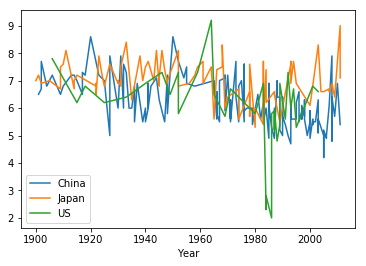

In [13]:
fig, ax = plt.subplots()
df[df['Country'] == 'China'].plot(x='Year', y='Magnitude', ax=ax,label='China');
df[df['Country']=='Japan'].plot(x='Year' , y='Magnitude',ax=ax,label='Japan');
df[df['Country']=='United States'].plot(x='Year',y='Magnitude',ax=ax,label='US');
#ax.set_title("CHINA , JAPAN ")

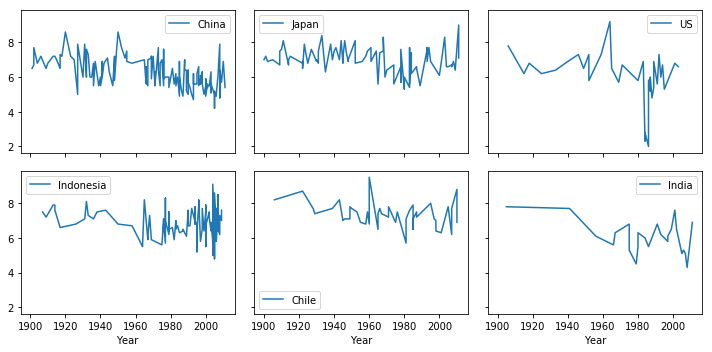

In [14]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(10,5))
df[df['Country'] == 'China'].plot(x='Year', y='Magnitude', ax=ax1,label='China');
df[df['Country']=='Japan'].plot(x='Year' , y='Magnitude',ax=ax2,label='Japan');
df[df['Country'] == 'United States'].plot(x='Year',y='Magnitude',ax=ax3,label='US')

df[df['Country'] == 'Indonesia'].plot(x='Year', y='Magnitude', ax=ax4,label='Indonesia');
df[df['Country']=='Chile'].plot(x='Year' , y='Magnitude',ax=ax5,label='Chile');
df[df['Country']=='India'].plot(x='Year',y='Magnitude',ax=ax6,label='India');

plt.tight_layout()

Dropdown(description='Country', options=('ALL', 'Afghanistan', 'Albania', 'Algeria', 'Argentina', 'Armenia', 'Australia', 'Azerbaijan', 'Bangladesh', 'Belgium', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Burma', 'Burundi', 'Canada', 'Chile', 'China', 'Colombia', 'Costa Rica', 'Cuba', 'Cyprus', 'Czech Republic', 'Democratic Republic of the Congo', 'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'England', 'Eritrea', 'Ethiopia', 'Fiji', 'France', 'Georgia', 'Ghana', 'Greece', 'Guadeloupe', 'Guatemala', 'Guinea', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Italy', 'Jamaica', 'Japan', 'Judea and Samaria', 'Kazakhstan', 'Kingdom of Yugoslavia', 'Kyrgyzstan', 'Macedonia', 'Malawi', 'Malaysia', 'Mandatory Palestine and Transjordan', 'Martinique', 'Mexico', 'Mongolia', 'Montenegro', 'Morocco', 'Mozambique', 'Nepal', 'Netherlands', 'New Zealand', 'Nicaragua', 'Pakistan', 'Panama', 'Papua New Guinea', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Puerto Rico', 'Romania', 'Russian Federation', 'Rwanda', 'Saint Pierre and Miquelon', 'Samoa', 'Saudi Arabia/Egypt', 'Serbia', 'Slovenia', 'Solomon Islands', 'South Africa', 'Spain', 'Sudan', 'Syrian Arab Republic', 'Taiwan', 'Tajik Soviet Socialist Republic', 'Tajikistan', 'Tanzania', 'Tunisia', 'Turkey', 'Turkmenistan', 'US Territory of Alaska', 'Uganda', 'United States', 'United States Minor Outlying Islands', 'Uzbekistan', 'Vanuatu', 'Venezuela', 'Vietnam', 'Wallis and Futuna', 'Yemen', 'Yugoslavia'), value='ALL')

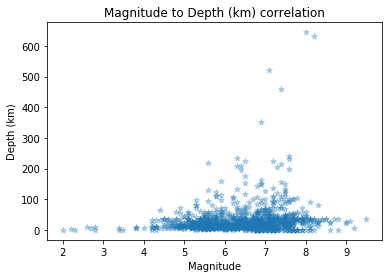

In [15]:
mag_dep = gdf.groupby(['Country','Magnitude','Depth (km)'])['Deaths'].sum()
mag_dep = mag_dep.reset_index()
mag_dep
plt.title('Magnitude to Depth (km) correlation')
plt.xlabel('Magnitude')
plt.ylabel('Depth (km)')
plt.scatter(mag_dep['Magnitude'], mag_dep['Depth (km)'], marker='*', alpha=0.3)#, s=mag_dep['Deaths'])

d_c = widgets.Dropdown(
    options=countries,
    value='ALL',
    description='Country',
    disabled=False,
)
display(d_c)

def plot_d(c_change):
    clear_output()
    country = c_change['new']
    plot_mag_dep = mag_dep.copy()
    test_mag_dep = mag_dep.loc[mag_dep['Country'] == country]
    display(d_c)
    plt.title('Magnitude to Depth (km) correlation for ' + country)
    plt.xlabel('Magnitude')
    plt.ylabel('Depth (km)')
    plt.scatter(test_mag_dep['Magnitude'],test_mag_dep['Depth (km)'], marker='*', alpha=0.3)

d_c.observe(plot_d, names='value')
#China

Dropdown(description='Country', index=18, options=('Afghanistan', 'Albania', 'Algeria', 'Argentina', 'Armenia', 'Australia', 'Azerbaijan', 'Bangladesh', 'Belgium', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Burma', 'Burundi', 'Canada', 'Chile', 'China', 'Colombia', 'Costa Rica', 'Cuba', 'Cyprus', 'Czech Republic', 'Democratic Republic of the Congo', 'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'England', 'Eritrea', 'Ethiopia', 'Fiji', 'France', 'Georgia', 'Ghana', 'Greece', 'Guadeloupe', 'Guatemala', 'Guinea', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Italy', 'Jamaica', 'Japan', 'Judea and Samaria', 'Kazakhstan', 'Kingdom of Yugoslavia', 'Kyrgyzstan', 'Macedonia', 'Malawi', 'Malaysia', 'Mandatory Palestine and Transjordan', 'Martinique', 'Mexico', 'Mongolia', 'Montenegro', 'Morocco', 'Mozambique', 'Nepal', 'Netherlands', 'New Zealand', 'Nicaragua', 'Pakistan', 'Panama', 'Papua New Guinea', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Puerto Rico', 'Romania', 'Russian Federation', 'Rwanda', 'Saint Pierre and Miquelon', 'Samoa', 'Saudi Arabia/Egypt', 'Serbia', 'Slovenia', 'Solomon Islands', 'South Africa', 'Spain', 'Sudan', 'Syrian Arab Republic', 'Taiwan', 'Tajik Soviet Socialist Republic', 'Tajikistan', 'Tanzania', 'Tunisia', 'Turkey', 'Turkmenistan', 'US Territory of Alaska', 'Uganda', 'United States', 'United States Minor Outlying Islands', 'Uzbekistan', 'Vanuatu', 'Venezuela', 'Vietnam', 'Wallis and Futuna', 'Yemen', 'Yugoslavia'), value='Colombia')

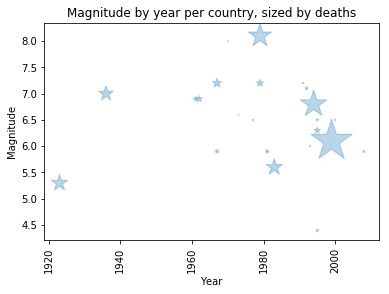

In [16]:
c_y_d = gdf.groupby(['Country','Year','Magnitude'])['Deaths'].sum()
c_y_d=c_y_d.reset_index()
c_y_d_select = c_y_d.loc[c_y_d['Country'] == 'Colombia']


plt.title('Magnitude by year per country, sized by deaths')
plt.xlabel('Year')
plt.xticks(rotation='vertical')
plt.ylabel('Magnitude')
plt.scatter(c_y_d_select['Year'],c_y_d_select['Magnitude'], marker='*', alpha=0.3, s=c_y_d_select['Deaths'])

countries.remove('ALL')

d_y_d = widgets.Dropdown(
    options=countries,
    value='Colombia',
    description='Country',
    disabled=False,
)
display(d_y_d)

def plot_c_y_d(c_y_d_change):
    clear_output()
    country = c_y_d_change['new']
    c_y_d_select = c_y_d.loc[c_y_d['Country']==country]
    display(d_y_d)
    plt.title('Magnitude by year for ' + country + ' sized by deaths')
    plt.xlabel('Year')
    plt.xticks(rotation='vertical')
    plt.ylabel('Magnitude')
    plt.scatter(c_y_d_select['Year'],c_y_d_select['Magnitude'], marker='*', alpha=0.3, s=c_y_d_select['Deaths'])

d_y_d.observe(plot_c_y_d, names='value')

In [17]:
import folium
new_map = folium.Map(location=[43.1,40.3], zoom_start=2)

for row in gdf.iterrows():
    row = list(row[1])
    try:
        folium.Marker([row[2],row[3]], popup=str(row[1]) + ' | ' + str(row[0]) + ' | Magnitude: ' + str(row[5]) + ' | Deaths: ' + str(row[-3])).add_to(new_map)
    except:
        continue
   
new_map